<a href="https://colab.research.google.com/github/Chienlovecode/Apple_stocks_predict/blob/main/Apple_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

#Define start day to fetch the dataset from the yahoo finance library

In [3]:
# Tạo Spark session
spark = SparkSession.builder.appName("StockDataProcessing").getOrCreate()

# Thiết lập thời gian tải dữ liệu
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

In [4]:
# Hàm tải dữ liệu từ Yahoo Finance
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [5]:
# Bước 1: Tải dữ liệu từ Yahoo Finance
df = load_data("AAPL")

# ✅ Xử lý tên cột: xoá multi-level index
df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]

# ✅ In lại tên cột để kiểm tra
print(df.columns)

# Bước 2: Tạo Spark DataFrame từ Pandas
df_spark = spark.createDataFrame(df)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


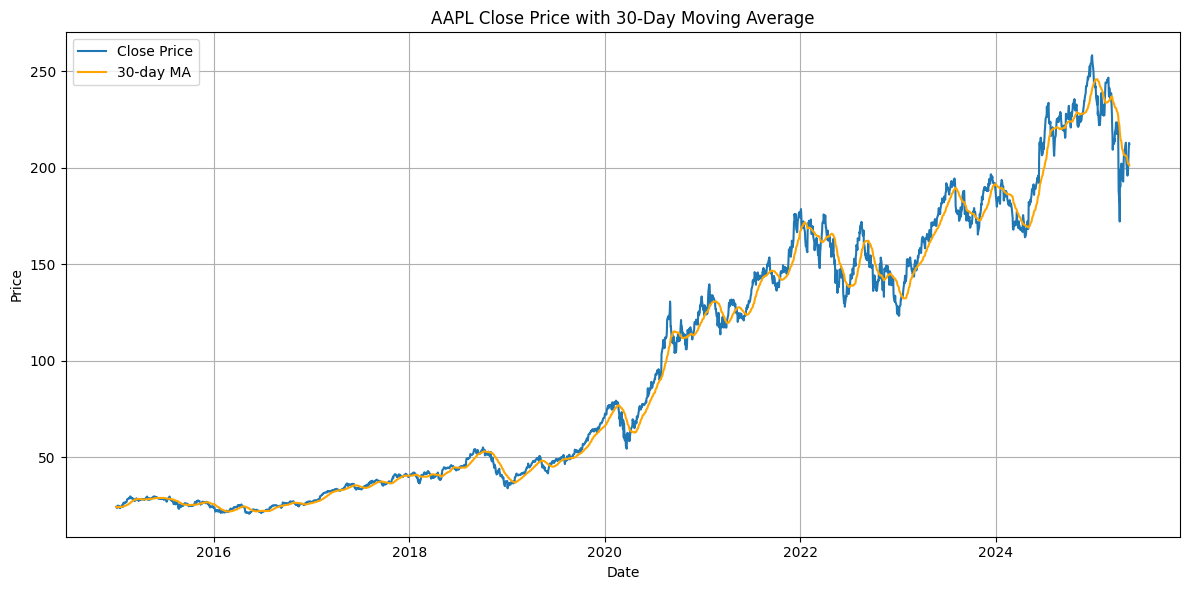

In [6]:
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

# Đảm bảo cột 'Date' là kiểu ngày
df_spark = df_spark.withColumn("Date", to_date(col("Date")))

# Giữ lại các cột cần thiết
df_spark = df_spark.select("Date", "Close")

# Tính MA 30 ngày
windowSpec = Window.orderBy("Date").rowsBetween(-29, 0)
df_spark = df_spark.withColumn("MA_30", avg("Close").over(windowSpec))

# Sắp xếp theo ngày
df_spark = df_spark.orderBy("Date")

# Chuyển về Pandas để vẽ
df_plot = df_spark.toPandas()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
plt.plot(df_plot["Date"], df_plot["MA_30"], label="30-day MA", color="orange")
plt.title("AAPL Close Price with 30-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
from pyspark.sql.functions import lag, when, lit
from pyspark.sql.window import Window

# Thêm cột change = Close - Close của ngày trước
windowSpec_lag = Window.orderBy("Date")
df_spark = df_spark.withColumn("prev_Close", lag("Close").over(windowSpec_lag))
df_spark = df_spark.withColumn("change", col("Close") - col("prev_Close"))

# Tính gain và loss
df_spark = df_spark.withColumn("gain", when(col("change") > 0, col("change")).otherwise(lit(0.0)))
df_spark = df_spark.withColumn("loss", when(col("change") < 0, -col("change")).otherwise(lit(0.0)))

# Cửa sổ 14 ngày để tính trung bình gain và loss
windowSpec_rsi = Window.orderBy("Date").rowsBetween(-13, 0)

df_spark = df_spark.withColumn("avg_gain", avg("gain").over(windowSpec_rsi))
df_spark = df_spark.withColumn("avg_loss", avg("loss").over(windowSpec_rsi))

# Tính RSI
df_spark = df_spark.withColumn(
    "RSI_14",
    when(col("avg_loss") == 0, lit(100))
    .otherwise(100 - (100 / (1 + col("avg_gain") / col("avg_loss"))))
)

In [9]:
df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").show(20)

+----------+------------------+------------------+-------------------+
|      Date|             Close|             MA_30|             RSI_14|
+----------+------------------+------------------+-------------------+
|2015-01-02|24.288576126098633|24.288576126098633|              100.0|
|2015-01-05|23.604326248168945| 23.94645118713379|                0.0|
|2015-01-06| 23.60655403137207|23.833152135213215|0.32452377247771835|
|2015-01-07| 23.93756675720215| 23.85925579071045|  32.75121940246467|
|2015-01-08| 24.85730743408203|24.058866119384767|  64.67897450640811|
|2015-01-09|24.883962631225586| 24.19638220469157|  65.15837543534549|
|2015-01-12| 24.27080726623535|24.207014356340682| 49.655246937337544|
|2015-01-13| 24.48630714416504|24.241925954818726|  53.54034161694315|
|2015-01-14|24.393001556396484| 24.25871213277181|  51.80926824915814|
|2015-01-15|23.730966567993164|24.205937576293945| 42.141655986306205|
|2015-01-16|23.546571731567383|24.145995226773348| 40.059628329691314|
|2015-

In [10]:
df_plot = df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").toPandas()

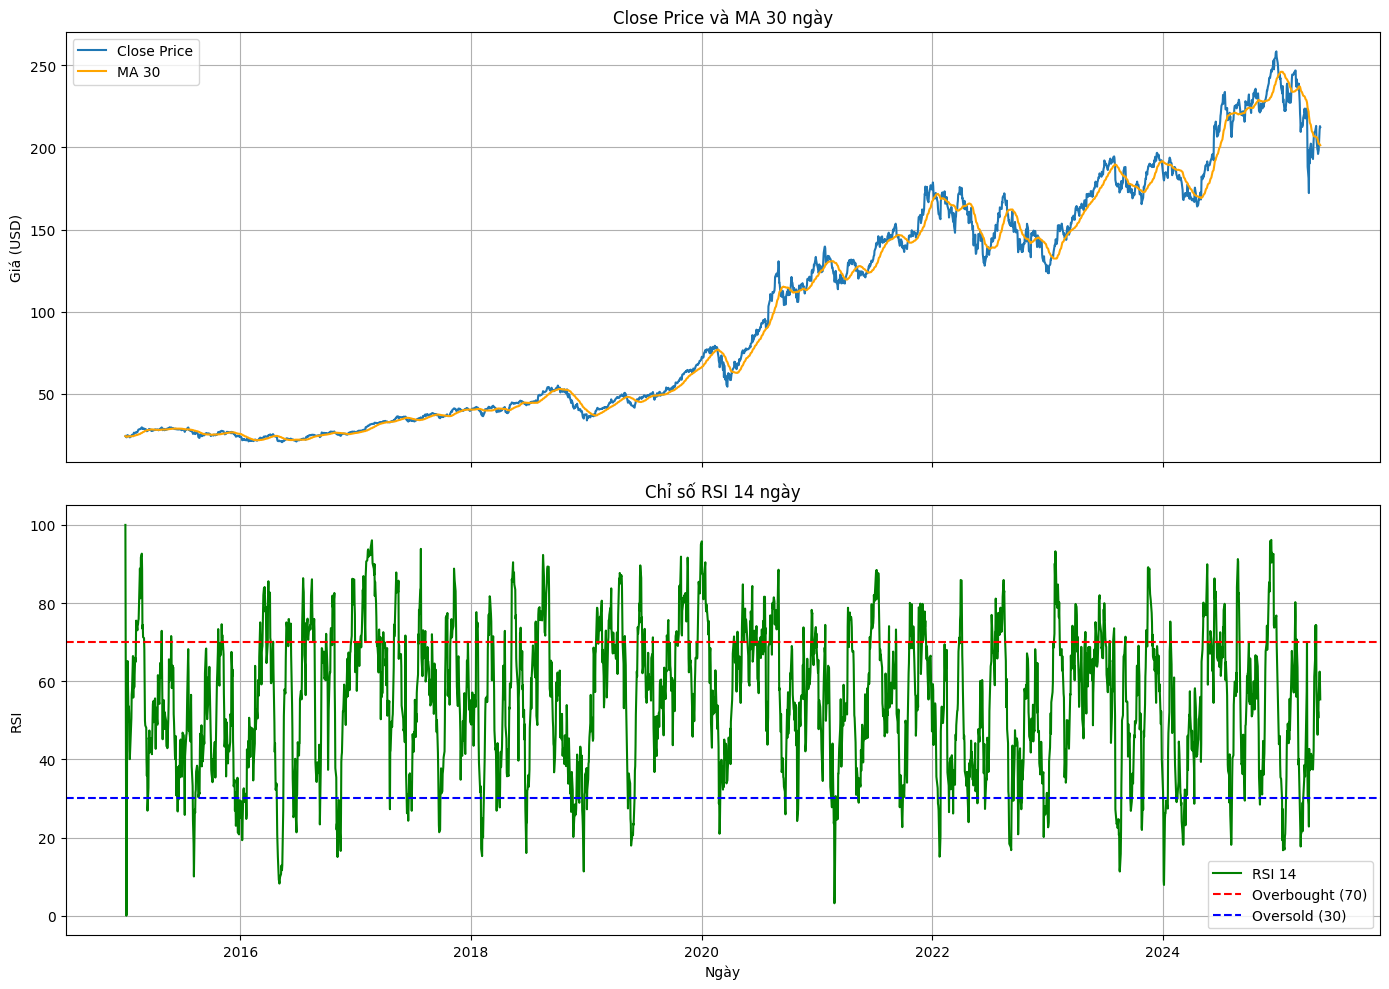

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Biểu đồ giá Close và MA_30
ax1.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
ax1.plot(df_plot["Date"], df_plot["MA_30"], label="MA 30", color="orange")
ax1.set_title("Close Price và MA 30 ngày")
ax1.set_ylabel("Giá (USD)")
ax1.legend()
ax1.grid(True)

# Biểu đồ RSI 14 ngày
ax2.plot(df_plot["Date"], df_plot["RSI_14"], label="RSI 14", color="green")
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
ax2.set_title("Chỉ số RSI 14 ngày")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Ngày")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Training the model

In [25]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential # Import the Sequential model
from tensorflow.keras.layers import LSTM, Dense, Dropout # Import necessary layers


# df_plot is assumed to have columns: Date, Close, MA_30, RSI_14

# Extract the 'Close' column for prediction
data = df_plot[["Close"]].values

# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a dataset with a window size (e.g., 60 days)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape data for LSTM input: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)

x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Keras model before compiling
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Proceed with compiling and training the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['MAE'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - MAE: 0.1082 - loss: 0.0298 - val_MAE: 0.0358 - val_loss: 0.0019
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - MAE: 0.0232 - loss: 0.0014 - val_MAE: 0.0270 - val_loss: 0.0012
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - MAE: 0.0203 - loss: 0.0011 - val_MAE: 0.0281 - val_loss: 0.0013
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - MAE: 0.0183 - loss: 8.4772e-04 - val_MAE: 0.0296 - val_loss: 0.0014
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - MAE: 0.0181 - loss: 8.4462e-04 - val_MAE: 0.0669 - val_loss: 0.0055
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - MAE: 0.0188 - loss: 8.7679e-04 - val_MAE: 0.0599 - val_loss: 0.0046
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - MAE: 0.0175 - loss: 7.8343e-04 - val_MAE: 0.0471 - val_loss: 0.0031
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - MAE: 0.0172 - loss: 6.9616e-04 - val_MAE: 0.0293 - val_loss: 0.0014
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - M